In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [37]:
# Read CSV files
raw_members = pd.read_csv('data/members.csv')
raw_song_extra_info = pd.read_csv('data/song_extra_info.csv')
raw_songs = pd.read_csv('data/songs.csv')
raw_test = pd.read_csv('data/test.csv')
raw_train = pd.read_csv('data/train.csv')

In [38]:
# Merge songs.csv and members.csv to train and test
train = raw_train.merge(raw_songs, on='song_id', how='left')
train = train.merge(raw_members, on='msno', how='left')

In [39]:
test = raw_test.merge(raw_songs, on='song_id', how='left')
test = test.merge(raw_members, on='msno', how='left')

In [40]:
# Drop redundent columns
test = test.drop('source_screen_name', axis=1)
test = test.drop('composer', axis=1)
test = test.drop('lyricist', axis=1)

# Fill the mean of columns into their NaN fields respectively
test['song_length'] = test['song_length'].fillna(test['song_length'].mean())
test['bd'] = test['bd'].replace(0, test['bd'].median())

# Fill the mode of columns into their NaN fields respectively
test['gender'] = test['gender'].fillna('unknown')
test['artist_name'] = test['artist_name'].fillna('unknown')
test['source_system_tab'] = test['source_system_tab'].fillna('my library')
test['source_type'] = test['source_type'].fillna('local-library')
test['genre_ids'] = test['genre_ids'].fillna(465)
test['language'] = test['language'].fillna(3.0)

In [41]:
### Deal with NaN fields ###

# Drop the rows contains NaN composer or lyricist
# train = train.dropna(subset=['composer'], how='all',axis=0)
# train = train.dropna(subset=['lyricist'], how='all',axis=0)

# Drop redundent columns
train = train.drop('source_screen_name', axis=1)
train = train.drop('composer', axis=1)
train = train.drop('lyricist', axis=1)

# Fill the mean of columns into their NaN fields respectively
train['song_length'] = train['song_length'].fillna(train['song_length'].mean())
train['bd'] = train['bd'].replace(0, train['bd'].median())

# Fill the mode of columns into their NaN fields respectively
train['gender'] = train['gender'].fillna('unknown')
train['artist_name'] = train['artist_name'].fillna('unknown')
train['source_system_tab'] = train['source_system_tab'].fillna('my library')
train['source_type'] = train['source_type'].fillna('local-library')
train['genre_ids'] = train['genre_ids'].fillna(465)
train['language'] = train['language'].fillna(3.0)

In [42]:
#test.to_csv('test_1.csv', sep=',')

In [43]:
#train.to_csv('train_1.csv', sep=',')

### genre_ids Dummy

In [133]:
# genre_ids Dummy
# dummies = pd.get_dummies(train['genre_ids'])
# atom_col = [str(c) for c in dummies.columns if '|' not in str(c)]
# for col in atom_col:
#     train[col] = dummies[[str(c) for c in dummies.columns if col in str(c)]].sum(axis=1)

In [140]:
# genre_ids Dummy
# dummies = pd.get_dummies(test['genre_ids'])
# atom_col = [str(c) for c in dummies.columns if '|' not in str(c)]
# for col in atom_col:
#     test[col] = dummies[[str(c) for c in dummies.columns if col in str(c)]].sum(axis=1)

### LGBM Preprocessing

In [2]:
train['song_score'] = np.nan
train['artist_score'] = np.nan
train['song_score'] = train.groupby(['song_id']).transform(lambda s: s.count())
train['artist_score'] = train.groupby(['artist_name']).transform(lambda s: s.count())

NameError: name 'train' is not defined

In [45]:
#train = train.drop(['source_system_tab'], axis=1)
#train = train.drop(['source_type'], axis=1)
train = train.drop(['song_length'], axis=1)
#train = train.drop(['artist_name'], axis=1)
#train = train.drop(['city'], axis=1)
train = train.drop(['registered_via'], axis=1)
train = train.drop(['registration_init_time'], axis=1)
train = train.drop(['expiration_date'], axis=1)

In [46]:
#test = test.drop(['source_system_tab'], axis=1)
#test = test.drop(['source_type'], axis=1)
test = test.drop(['song_length'], axis=1)
#train = train.drop(['artist_name'], axis=1)
#train = train.drop(['city'], axis=1)
test = test.drop(['registered_via'], axis=1)
test = test.drop(['registration_init_time'], axis=1)
test = test.drop(['expiration_date'], axis=1)

In [47]:
test['song_score'] = np.nan
test['artist_score'] = np.nan
test['song_score'] = test.groupby(['song_id']).transform(lambda s: s.count())
test['artist_score'] = test.groupby(['artist_name']).transform(lambda s: s.count())

### LGBM Start

In [ ]:
test = pd.read_csv('test_lgbm.csv')
train = pd.read_csv('train_lgbm.csv')

In [ ]:
# train['language_score'] = np.nan
# train['genre_score'] = np.nan
# train['language_score'] = train.groupby(['msno','language']).transform(lambda s: s.count())
# train['genre_score'] = train.groupby(['msno','genre_ids']).transform(lambda s: s.count())
train['user_song_score'] = np.nan
train['user_artist_score'] = np.nan
train['user_song_score'] = train.groupby(['msno','song_id']).transform(lambda s: s.count())
train['user_artist_score'] = train.groupby(['msno','artist_name']).transform(lambda s: s.count())

In [ ]:
# test['language_score'] = np.nan
# test['genre_score'] = np.nan
# test['language_score'] = test.groupby(['msno','language']).transform(lambda s: s.count())
# test['genre_score'] = test.groupby(['msno','genre_ids']).transform(lambda s: s.count())
test['user_song_score'] = np.nan
test['user_artist_score'] = np.nan
test['user_song_score'] = test.groupby(['msno','song_id']).transform(lambda s: s.count())
test['user_artist_score'] = test.groupby(['msno','artist_name']).transform(lambda s: s.count())

### LGBM

In [ ]:
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

In [ ]:
X = train.drop(['target'], axis=1)
y = train['target'].values

X_test = test.drop(['id'], axis=1)
ids = test['id'].values

In [ ]:
d_train = lgb.Dataset(X, y)
watchlist = [d_train]

In [ ]:
print('Training LGBM model...')
params = {}
params['learning_rate'] = 0.2
params['application'] = 'binary'
params['max_depth'] = 10
params['num_leaves'] = 2**10
params['verbosity'] = 0
params['metric'] = 'auc'

In [ ]:
model = lgb.train(params, train_set=d_train, num_boost_round=100, valid_sets=watchlist, verbose_eval=5)

In [13]:
p_test = model.predict(X_test)

In [14]:
subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = p_test
subm.to_csv('submission.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

In [58]:
test.to_csv('test_lgbm.csv', sep=',')
train.to_csv('train_lgbm.csv', sep=',')

### Backup 

In [5]:
train['language_score'] = np.nan
train['genre_score'] = np.nan
train['language_score'] = train.groupby(['msno','language']).transform(lambda s: s.count())
train['genre_score'] = train.groupby(['msno','genre_ids']).transform(lambda s: s.count())

In [6]:
train['language_score'] = np.log(train['language_score'], dtype='float64')
train['genre_score'] = np.log(train['genre_score'], dtype='float64')

In [7]:
# Dummy
train = pd.get_dummies(data=train, columns=['gender'])
train = pd.get_dummies(data=train, columns=['genre_ids'])
train = pd.get_dummies(data=train, columns=['language'])

In [8]:
train = train.drop('bd', axis=1)
train = train.drop('msno', axis=1)
train = train.drop('song_id', axis=1)

In [9]:
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
label_m = train[:3000000]['target']
label_m = np.array(label_m)

In [10]:
train = train[:3000000].drop('target', axis=1)
train = minmax_scale.fit_transform(train)

In [25]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(max_depth=5)
regr.fit(train[:2200000], label_m[:2200000])

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [26]:
label_m_47 = regr.predict(train[2200000:3000000])

In [28]:
count = 0
for i, j in zip(np.nditer(label_m[2200000:3000000]), np.nditer(label_m_47)):
    if(j > 0.5):
        check = 1
    else:
        check = 0
    if(i == check):
        count+=1
print(count / 800000)

0.5386575


In [18]:
model = Sequential()
model.add(Dense(units=1000, input_dim=587, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1000, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
train_history = model.fit(x=train, y=label_m, validation_split=0.2, epochs=10, batch_size=10000, verbose=2)

Train on 2400000 samples, validate on 600000 samples
Epoch 1/10
717s - loss: 0.6536 - acc: 0.6334 - val_loss: 0.7024 - val_acc: 0.5468
Epoch 2/10
715s - loss: 0.6491 - acc: 0.6383 - val_loss: 0.7049 - val_acc: 0.5468
Epoch 3/10
718s - loss: 0.6484 - acc: 0.6390 - val_loss: 0.7071 - val_acc: 0.5449
Epoch 4/10
714s - loss: 0.6480 - acc: 0.6396 - val_loss: 0.7015 - val_acc: 0.5473
Epoch 5/10
715s - loss: 0.6475 - acc: 0.6398 - val_loss: 0.7031 - val_acc: 0.5487
Epoch 6/10
714s - loss: 0.6471 - acc: 0.6401 - val_loss: 0.7050 - val_acc: 0.5465
Epoch 7/10
714s - loss: 0.6469 - acc: 0.6405 - val_loss: 0.7049 - val_acc: 0.5486
Epoch 8/10
715s - loss: 0.6466 - acc: 0.6407 - val_loss: 0.7059 - val_acc: 0.5475
Epoch 9/10
714s - loss: 0.6464 - acc: 0.6408 - val_loss: 0.7054 - val_acc: 0.5489
Epoch 10/10
714s - loss: 0.6463 - acc: 0.6411 - val_loss: 0.7058 - val_acc: 0.5482


In [23]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history')
    plt.ylabel(train)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

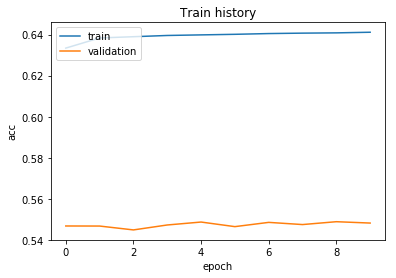

In [24]:
show_train_history(train_history,'acc','val_acc')

### For Testing and Backup ###

In [9]:
# Convert age into labels
age_bins = [-999, 20, 23, 26, 29, 40, 50, 999]
age_labels = ['0-20', '21-23', '24-26', '27-29', '30-40', '40-50', '50+']
train['bd_range'] = pd.cut(train['bd'], bins=age_bins, labels=age_labels, include_lowest=True)
train = pd.get_dummies(data=train, columns=['bd_range'])
train = train.drop('bd', axis=1)

In [10]:
# Get total count
train['song_id'] = train.groupby('song_id', as_index=False)['song_id'].transform(lambda s: s.count())
train['artist_name'] = train.groupby('artist_name', as_index=False)['artist_name'].transform(lambda s: s.count())
# train['composer'] = train.groupby('composer', as_index=False)['composer'].transform(lambda s: s.count())
# train['lyricist'] = train.groupby('lyricist', as_index=False)['lyricist'].transform(lambda s: s.count())

In [2]:
train = pd.read_csv('train_3.csv')

In [3]:
train = train.drop('genre_ids', axis=1)

In [4]:
train = train.drop('song_length', axis=1)

In [4]:
song_length_bins = [1, 214726, 241812, 272160, 10851800]
p_labels = ['0%-25%', '25%-50%', '50%-75%', '75%-100%']
train['song_length_range'] = pd.cut(train['song_length'], bins=song_length_bins, labels=p_labels, include_lowest=True)
train = pd.get_dummies(data=train, columns=['song_length_range'])

In [16]:
#train = train.drop('song_length', axis=1)
#train = train.drop('artist_name', axis=1)

In [48]:
train[:10]

,target,artist_name,1000,1007,1011,1019,1026,1033,1040,1047,...,bd_range_21-23,bd_range_24-26,bd_range_27-29,bd_range_30-40,bd_range_40-50,bd_range_50+,artist_name_range_0%-25%,artist_name_range_25%-50%,artist_name_range_50%-75%,artist_name_range_75%-100%
0,1,1140,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,303616,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,289,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1,0,0,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,427,0,0,1,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,1,1692,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,1,8188,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,1,1172,0,0,1,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,1,9211,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,1,9211,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
train = train.drop('registered_via', axis=1)

ValueError: labels ['registered_via'] not contained in axis

In [5]:
train[train.columns[1]] = np.log(train[train.columns[1]], dtype='float64')

In [6]:
train = train.dropna(subset=['bd_range_0-20'], how='all',axis=0)
label_m = train[train.columns[0]]
label_m = np.array(label_m)
#feature_m = train.drop('target', axis=1)
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
feature_m = minmax_scale.fit_transform(feature_m)

NameError: name 'feature_m' is not defined

In [7]:
feature_m = train.drop('target', axis=1)
feature_m = minmax_scale.fit_transform(feature_m)

### Training Model ##

In [8]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(max_depth=15)
regr.fit(feature_m[:4000000], label_m[:4000000])

DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [9]:
label_m_47 = regr.predict(feature_m[4000000:7000000])

In [10]:
count = 0
for i, j in zip(np.nditer(label_m[4000000:7000000]), np.nditer(label_m_47)):
    if(j > 0.5):
        check = 1
    else:
        check = 0
    if(i == check):
        count+=1
print(count / 3000000)

0.590382


In [44]:
model = Sequential()
model.add(Dense(units=1000, input_dim=276, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1000, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

In [45]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              277000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1001      
Total params: 1,279,001
Trainable params: 1,279,001
Non-trainable params: 0
_________________________________________________________________


In [47]:
train_history = model.fit(x=feature_m, y=label_m, validation_split=0.5, epochs=10, batch_size=300000, verbose=2)

Train on 3688648 samples, validate on 3688648 samples
Epoch 1/10


KeyboardInterrupt: 

In [48]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history')
    plt.ylabel(train)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

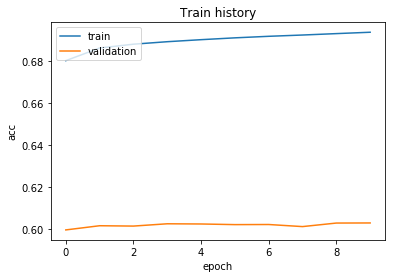

In [49]:
show_train_history(train_history,'acc','val_acc')

In [4]:
%%writefile kkbox.py

UsageError: %%writefile is a cell magic, but the cell body is empty.
